# Simpy

## Introduction to SimPy

**SimPy** is a process-based discrete-event simulation framework based on standard Python. It's perfect for modeling systems where:
- Active components (customers, vehicles, agents) interact with each other
- Resources are limited (servers, checkout counters, fuel pumps)
- Events occur at discrete time points

### Key Concepts:
1. **Environment**: The simulation world that manages time and events
2. **Processes**: Active components defined by Python generator functions
3. **Events**: Things that happen at specific times (timeouts, requests, releases)
4. **Resources**: Shared, limited-capacity objects (servers, machines, storage)


## 1. Basic Concepts: Your First Process

In [1]:
import simpy

def car(env, name):
    """A simple car process that alternates between parking and driving."""
    while True:
        print(f'{name} starts parking at time {env.now}')
        parking_duration = 5
        yield env.timeout(parking_duration)  # Wait for parking_duration time units
        
        print(f'{name} starts driving at time {env.now}')
        trip_duration = 2
        yield env.timeout(trip_duration)  # Wait for trip_duration time units

# Create environment and run simulation
env = simpy.Environment()
env.process(car(env, 'Car-1'))
env.run(until=15)  # Run simulation until time 15

Car-1 starts parking at time 0
Car-1 starts driving at time 5
Car-1 starts parking at time 7
Car-1 starts driving at time 12
Car-1 starts parking at time 14


### Key Points:
- **Generator Function**: Process functions use `yield` to pause and resume
- **env.timeout(duration)**: Creates a timeout event that triggers after `duration` time units
- **env.now**: Current simulation time
- **env.process()**: Registers a process with the environment
- **env.run(until=x)**: Runs the simulation until time x

## 2. Multiple Processes - Clock Example

In [2]:
def clock(env, name, tick):
    """A clock that ticks at regular intervals."""
    while True:
        print(f'{name}: {env.now}')
        yield env.timeout(tick)

# Create multiple processes
env = simpy.Environment()
env.process(clock(env, 'Fast Clock', 0.5))
env.process(clock(env, 'Slow Clock', 1))
env.run(until=2)

Fast Clock: 0
Slow Clock: 0
Fast Clock: 0.5
Slow Clock: 1
Fast Clock: 1.0
Fast Clock: 1.5


## 3. Resources - Basic Usage

Resources represent limited-capacity objects that processes compete for. Think of:
- Gas stations with limited pumps
- Servers with limited capacity
- Parking lots with limited spaces

In [3]:
def car_charging(env, name, bcs, driving_time, charge_duration):
    """Car drives to battery charging station, charges, and leaves."""
    # Drive to the charging station
    yield env.timeout(driving_time)
    
    print(f'{name} arriving at {env.now}')
    
    # Request a charging spot
    with bcs.request() as req:
        yield req  # Wait until a spot is available
        
        # Start charging
        print(f'{name} starting to charge at {env.now}')
        yield env.timeout(charge_duration)
        print(f'{name} leaving at {env.now}')

# Create environment and resource
env = simpy.Environment()
battery_charging_station = simpy.Resource(env, capacity=2)  # 2 charging spots

# Create 4 cars with different arrival times
for i in range(4):
    env.process(car_charging(env, f'Car-{i}', battery_charging_station, i*2, 5))

env.run()

Car-0 arriving at 0
Car-0 starting to charge at 0
Car-1 arriving at 2
Car-1 starting to charge at 2
Car-2 arriving at 4
Car-0 leaving at 5
Car-2 starting to charge at 5
Car-3 arriving at 6
Car-1 leaving at 7
Car-3 starting to charge at 7
Car-2 leaving at 10
Car-3 leaving at 12


**Notice:** Cars 0 and 1 charge immediately, while Cars 2 and 3 must wait for available spots.

## 4. PriorityResource - Queue Jumping

When some processes are more important than others, use `PriorityResource`. Lower priority numbers = higher importance.

In [5]:
def patient(name, env, doctor, wait_time, treatment_time, priority):
    """Patient arrives, waits for doctor with priority, gets treatment."""
    yield env.timeout(wait_time)
    
    print(f'{name} arrives at {env.now} (Priority: {priority})')
    with doctor.request(priority=priority) as req:
        yield req
        print(f'{name} starts treatment at {env.now}')
        yield env.timeout(treatment_time)
        print(f'{name} finishes at {env.now}')

env = simpy.Environment()
doctor = simpy.PriorityResource(env, capacity=1)

# Create patients with different priorities
env.process(patient('Patient-Regular', env, doctor, wait_time=0, treatment_time=3, priority=5))
env.process(patient('Patient-Normal', env, doctor, wait_time=1, treatment_time=2, priority=3))
env.process(patient('Patient-Emergency', env, doctor, wait_time=2, treatment_time=2, priority=1))

env.run()

Patient-Regular arrives at 0 (Priority: 5)
Patient-Regular starts treatment at 0
Patient-Normal arrives at 1 (Priority: 3)
Patient-Emergency arrives at 2 (Priority: 1)
Patient-Regular finishes at 3
Patient-Emergency starts treatment at 3
Patient-Emergency finishes at 5
Patient-Normal starts treatment at 5
Patient-Normal finishes at 7


**Notice:** Even though the emergency patient arrives last, they get treated before the normal patient due to higher priority (lower number).

## 5. PreemptiveResource - Interrupting Current Users

Sometimes high-priority requests need to kick out current users. This is called **preemption**.

In [7]:
def cpu_task(name, env, cpu, wait, priority, duration):
    """Task requests CPU with priority and can be preempted."""
    yield env.timeout(wait)
    
    print(f'{name} requesting CPU at {env.now} (Priority: {priority})')
    with cpu.request(priority=priority) as req:
        try:
            yield req
            print(f'{name} got CPU at {env.now}')
            yield env.timeout(duration)
            print(f'{name} completed at {env.now}')
        except simpy.Interrupt as interrupt:
            # Task was preempted!
            usage = env.now - interrupt.cause.usage_since
            print(f'{name} PREEMPTED at {env.now} (used {usage:.2f} time units)')

env = simpy.Environment()
cpu = simpy.PreemptiveResource(env, capacity=1)

# Low priority task starts first
env.process(cpu_task('Low-Priority-Task', env, cpu, wait=0, priority=5, duration=10))

# High priority task arrives later and preempts the first task
env.process(cpu_task('High-Priority-Task', env, cpu, wait=2, priority=1, duration=3))

env.run()

Low-Priority-Task requesting CPU at 0 (Priority: 5)
Low-Priority-Task got CPU at 0
High-Priority-Task requesting CPU at 2 (Priority: 1)
Low-Priority-Task PREEMPTED at 2 (used 2.00 time units)
High-Priority-Task got CPU at 2
High-Priority-Task completed at 5


## 6. Container - Modeling Continuous/Bulk Resources

Containers model production and consumption of homogeneous bulk (like water, fuel, or discrete items like apples).

In [8]:
class GasStation:
    def __init__(self, env):
        self.fuel_dispensers = simpy.Resource(env, capacity=2)  # 2 pumps
        self.gas_tank = simpy.Container(env, init=100, capacity=1000)  # Tank: 100/1000 liters
        self.monitoring = env.process(self.monitor_tank(env))
    
    def monitor_tank(self, env):
        """Monitor tank level and call tanker when low."""
        while True:
            if self.gas_tank.level < 100:
                print(f'🚨 Tank low ({self.gas_tank.level}L)! Calling tanker at {env.now}')
                env.process(tanker(env, self))
            yield env.timeout(15)

def tanker(env, gas_station):
    """Tanker refills the gas station."""
    yield env.timeout(10)  # Travel time
    print(f'🚚 Tanker arriving at {env.now}')
    amount = gas_station.gas_tank.capacity - gas_station.gas_tank.level
    yield gas_station.gas_tank.put(amount)  # Fill tank
    print(f'⛽ Tank refilled to {gas_station.gas_tank.level}L at {env.now}')

def car_refuel(name, env, gas_station):
    """Car arrives, refuels, and leaves."""
    print(f'🚗 {name} arriving at {env.now}')
    with gas_station.fuel_dispensers.request() as req:
        yield req
        print(f'   {name} starts refueling at {env.now} (Tank level: {gas_station.gas_tank.level}L)')
        yield gas_station.gas_tank.get(40)  # Take 40 liters
        yield env.timeout(5)  # Refueling time
        print(f'   {name} done at {env.now} (Tank level: {gas_station.gas_tank.level}L)')

def car_generator(env, gas_station):
    """Generate cars arriving at the gas station."""
    for i in range(5):
        env.process(car_refuel(f'Car-{i}', env, gas_station))
        yield env.timeout(5)

env = simpy.Environment()
gas_station = GasStation(env)
env.process(car_generator(env, gas_station))
env.run(until=50)

🚗 Car-0 arriving at 0
   Car-0 starts refueling at 0 (Tank level: 100L)
🚗 Car-1 arriving at 5
   Car-0 done at 5 (Tank level: 60L)
   Car-1 starts refueling at 5 (Tank level: 60L)
🚗 Car-2 arriving at 10
   Car-1 done at 10 (Tank level: 20L)
   Car-2 starts refueling at 10 (Tank level: 20L)
🚨 Tank low (20L)! Calling tanker at 15
🚗 Car-3 arriving at 15
   Car-3 starts refueling at 15 (Tank level: 20L)
🚗 Car-4 arriving at 20
🚚 Tanker arriving at 25
⛽ Tank refilled to 920L at 25
   Car-2 done at 30 (Tank level: 920L)
   Car-3 done at 30 (Tank level: 920L)
   Car-4 starts refueling at 30 (Tank level: 920L)
   Car-4 done at 35 (Tank level: 880L)


**Key Container Methods:**
- `put(amount)`: Add amount to container
- `get(amount)`: Remove amount from container  
- `level`: Current amount in container
- `capacity`: Maximum capacity

## 7. Store - Modeling Discrete Objects

Stores manage production and consumption of concrete Python objects (not just amounts).

In [9]:
def producer(env, store):
    """Produces items and puts them in the store."""
    for i in range(6):
        yield env.timeout(2)
        item = f'Widget-{i}'
        yield store.put(item)
        print(f'📦 Produced {item} at {env.now}')

def consumer(name, env, store):
    """Consumes items from the store."""
    while True:
        yield env.timeout(3)
        print(f'   {name} requesting item at {env.now}')
        item = yield store.get()
        print(f'   {name} got {item} at {env.now}')

env = simpy.Environment()
warehouse = simpy.Store(env, capacity=3)  # Max 3 items in store

env.process(producer(env, warehouse))
env.process(consumer('Consumer-A', env, warehouse))
env.process(consumer('Consumer-B', env, warehouse))

env.run(until=20)

📦 Produced Widget-0 at 2
   Consumer-A requesting item at 3
   Consumer-B requesting item at 3
   Consumer-A got Widget-0 at 3
📦 Produced Widget-1 at 4
   Consumer-B got Widget-1 at 4
   Consumer-A requesting item at 6
📦 Produced Widget-2 at 6
   Consumer-A got Widget-2 at 6
   Consumer-B requesting item at 7
📦 Produced Widget-3 at 8
   Consumer-B got Widget-3 at 8
   Consumer-A requesting item at 9
📦 Produced Widget-4 at 10
   Consumer-A got Widget-4 at 10
   Consumer-B requesting item at 11
📦 Produced Widget-5 at 12
   Consumer-B got Widget-5 at 12
   Consumer-A requesting item at 13
   Consumer-B requesting item at 15


## 8. FilterStore - Selective Retrieval

FilterStore lets you retrieve items based on a filter function.

In [10]:
from collections import namedtuple

# Define a machine with size and speed attributes
Machine = namedtuple('Machine', ['size', 'speed'])

def job(name, env, machine_shop, required_size):
    """Job requests a machine of specific size."""
    print(f'🏭 {name} needs size-{required_size} machine at {env.now}')
    
    # Request machine with specific size using filter
    machine = yield machine_shop.get(lambda m: m.size == required_size)
    print(f'   {name} got {machine} at {env.now}')
    
    # Use the machine
    yield env.timeout(machine.speed)
    
    # Return machine to shop
    yield machine_shop.put(machine)
    print(f'   {name} returned {machine} at {env.now}')

env = simpy.Environment()
machine_shop = simpy.FilterStore(env, capacity=3)

# Pre-populate shop with different machines
machine_shop.items = [
    Machine(size=1, speed=2),  # Small, slow
    Machine(size=2, speed=1),  # Large, fast
    Machine(size=1, speed=3),  # Small, very slow
]

# Create jobs with different requirements
env.process(job('Job-A', env, machine_shop, required_size=1))
env.process(job('Job-B', env, machine_shop, required_size=2))
env.process(job('Job-C', env, machine_shop, required_size=1))

env.run()

🏭 Job-A needs size-1 machine at 0
🏭 Job-B needs size-2 machine at 0
🏭 Job-C needs size-1 machine at 0
   Job-A got Machine(size=1, speed=2) at 0
   Job-B got Machine(size=2, speed=1) at 0
   Job-C got Machine(size=1, speed=3) at 0
   Job-B returned Machine(size=2, speed=1) at 1
   Job-A returned Machine(size=1, speed=2) at 2
   Job-C returned Machine(size=1, speed=3) at 3


## 9. PriorityStore - Items with Priorities

Items are retrieved in priority order (lower priority number = higher importance).

In [11]:
def bug_reporter(env, bug_tracker):
    """Reports bugs with different priorities."""
    bugs = [
        simpy.PriorityItem(priority='P2', item='Bug #101: UI glitch'),
        simpy.PriorityItem(priority='P0', item='Bug #102: System crash'),
        simpy.PriorityItem(priority='P3', item='Bug #103: Typo in label'),
        simpy.PriorityItem(priority='P1', item='Bug #104: Data loss'),
    ]
    
    for bug in bugs:
        yield env.timeout(1)
        print(f'🐛 Logged: {bug} at {env.now}')
        yield bug_tracker.put(bug)

def developer(env, bug_tracker):
    """Fixes bugs in priority order."""
    while True:
        yield env.timeout(3)
        bug = yield bug_tracker.get()
        print(f'   🔧 Fixed: {bug} at {env.now}')

env = simpy.Environment()
bug_tracker = simpy.PriorityStore(env)

env.process(bug_reporter(env, bug_tracker))
env.process(developer(env, bug_tracker))

env.run()

🐛 Logged: PriorityItem(priority='P2', item='Bug #101: UI glitch') at 1
🐛 Logged: PriorityItem(priority='P0', item='Bug #102: System crash') at 2
🐛 Logged: PriorityItem(priority='P3', item='Bug #103: Typo in label') at 3
   🔧 Fixed: PriorityItem(priority='P0', item='Bug #102: System crash') at 3
🐛 Logged: PriorityItem(priority='P1', item='Bug #104: Data loss') at 4
   🔧 Fixed: PriorityItem(priority='P1', item='Bug #104: Data loss') at 6
   🔧 Fixed: PriorityItem(priority='P2', item='Bug #101: UI glitch') at 9
   🔧 Fixed: PriorityItem(priority='P3', item='Bug #103: Typo in label') at 12


**Notice:** Bugs are fixed in priority order (P0 → P1 → P2 → P3), not in the order they were reported.

## 10. Process Interaction - Waiting for Other Processes

Processes can wait for other processes to finish using `yield other_process`.

In [12]:
def washing(env, duration):
    """Wash clothes."""
    print(f'🧺 Washing started at {env.now}')
    yield env.timeout(duration)
    print(f'🧺 Washing done at {env.now}')

def drying(env, duration):
    """Dry clothes."""
    print(f'🌀 Drying started at {env.now}')
    yield env.timeout(duration)
    print(f'🌀 Drying done at {env.now}')

def laundry(env):
    """Complete laundry process: wash then dry."""
    print(f'👕 Starting laundry at {env.now}')
    
    # Start washing and wait for it to finish
    wash_process = env.process(washing(env, duration=5))
    yield wash_process
    
    print(f'   Moving to dryer...')
    
    # Start drying and wait for it to finish
    dry_process = env.process(drying(env, duration=3))
    yield dry_process
    
    print(f'✅ Laundry complete at {env.now}')

env = simpy.Environment()
env.process(laundry(env))
env.run()

👕 Starting laundry at 0
🧺 Washing started at 0
🧺 Washing done at 5
   Moving to dryer...
🌀 Drying started at 5
🌀 Drying done at 8
✅ Laundry complete at 8


## 11. Interrupting Processes

One process can interrupt another using `process.interrupt()`.

In [13]:
def worker(env, name):
    """Worker that can be interrupted."""
    print(f'👷 {name} started working at {env.now}')
    try:
        yield env.timeout(10)  # Try to work for 10 time units
        print(f'👷 {name} finished work at {env.now}')
    except simpy.Interrupt as interrupt:
        print(f'⚠️  {name} was interrupted at {env.now}! Reason: {interrupt.cause}')

def supervisor(env, worker_process):
    """Supervisor that interrupts worker after some time."""
    yield env.timeout(5)
    print(f'👔 Supervisor: Interrupting worker at {env.now}')
    worker_process.interrupt('Emergency meeting!')

env = simpy.Environment()
worker_proc = env.process(worker(env, 'Bob'))
env.process(supervisor(env, worker_proc))
env.run()

👷 Bob started working at 0
👔 Supervisor: Interrupting worker at 5
⚠️  Bob was interrupted at 5! Reason: Emergency meeting!


## 12. Events - AnyOf and AllOf

You can wait for multiple events using `AnyOf` (any event) or `AllOf` (all events).

In [14]:
def task(env, name, duration):
    """A task that takes some duration."""
    print(f'⚙️  {name} started at {env.now}')
    yield env.timeout(duration)
    print(f'✅ {name} finished at {env.now}')
    return f'{name} result'

# Example 1: Wait for ANY event to complete
print("="*50)
print("Example 1: AnyOf - Wait for the FIRST task to complete")
print("="*50)

def wait_for_any(env):
    """Wait for any task to complete."""
    task1 = env.process(task(env, 'Task-A', 3))
    task2 = env.process(task(env, 'Task-B', 5))
    task3 = env.process(task(env, 'Task-C', 2))
    
    # Wait for ANY task to finish
    results = yield simpy.AnyOf(env, [task1, task2, task3])
    print(f'🎯 First task completed! Results: {results}')

env = simpy.Environment()
env.process(wait_for_any(env))
env.run()

# Example 2: Wait for ALL events to complete
print("\n" + "="*50)
print("Example 2: AllOf - Wait for ALL tasks to complete")
print("="*50)

def wait_for_all(env):
    """Wait for all tasks to complete."""
    task1 = env.process(task(env, 'Task-X', 3))
    task2 = env.process(task(env, 'Task-Y', 5))
    task3 = env.process(task(env, 'Task-Z', 2))
    
    # Wait for ALL tasks to finish
    results = yield simpy.AllOf(env, [task1, task2, task3])
    print(f'🎯 All tasks completed! Results: {results}')

env = simpy.Environment()
env.process(wait_for_all(env))
env.run()

Example 1: AnyOf - Wait for the FIRST task to complete
⚙️  Task-A started at 0
⚙️  Task-B started at 0
⚙️  Task-C started at 0
✅ Task-C finished at 2
🎯 First task completed! Results: <ConditionValue {<Process(task) object at 0x79260bdf8cd0>: 'Task-C result'}>
✅ Task-A finished at 3
✅ Task-B finished at 5

Example 2: AllOf - Wait for ALL tasks to complete
⚙️  Task-X started at 0
⚙️  Task-Y started at 0
⚙️  Task-Z started at 0
✅ Task-Z finished at 2
✅ Task-X finished at 3
✅ Task-Y finished at 5
🎯 All tasks completed! Results: <ConditionValue {<Process(task) object at 0x79260bdf8dd0>: 'Task-X result', <Process(task) object at 0x79260bdf9050>: 'Task-Y result', <Process(task) object at 0x79260bdf8cd0>: 'Task-Z result'}>


## 13. Monitoring and Data Collection

Track simulation statistics by monitoring resource usage and events.

Customer-6 arrives at 0.4
Customer-6 starts service at 0.4
Customer-6 leaves at 2.8
Customer-5 arrives at 3.3
Customer-5 starts service at 3.3
Customer-8 arrives at 3.3
Customer-8 starts service at 3.3
Customer-1 arrives at 4.1
Customer-5 leaves at 6.3
Customer-1 starts service at 6.3
Customer-4 arrives at 6.3
Customer-8 leaves at 6.5
Customer-4 starts service at 6.5
Customer-4 leaves at 8.5
Customer-1 leaves at 8.7
Customer-0 arrives at 9.6
Customer-0 starts service at 9.6
Customer-7 arrives at 9.7
Customer-7 starts service at 9.7
Customer-2 arrives at 11.0
Customer-0 leaves at 11.6
Customer-2 starts service at 11.6
Customer-9 arrives at 12.1
Customer-7 leaves at 12.8
Customer-9 starts service at 12.8
Customer-3 arrives at 13.4
Customer-9 leaves at 14.9
Customer-3 starts service at 14.9
Customer-2 leaves at 15.0
Customer-3 leaves at 17.0


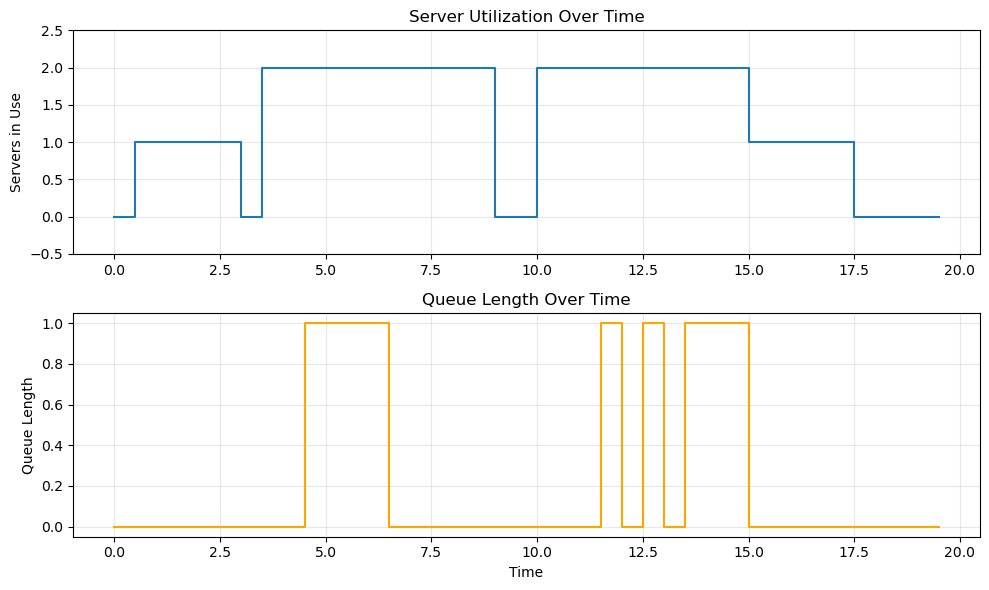


📊 Statistics:
   Average Utilization: 65.0%
   Average Queue Length: 0.23
   Maximum Queue Length: 1


In [15]:
import matplotlib.pyplot as plt

class MonitoredResource:
    """Resource with monitoring capabilities."""
    def __init__(self, env, capacity):
        self.resource = simpy.Resource(env, capacity)
        self.env = env
        self.capacity = capacity
        
        # Data collection
        self.times = []
        self.usage = []
        self.queue_length = []
        
        # Start monitoring
        env.process(self.monitor())
    
    def monitor(self):
        """Continuously monitor resource usage."""
        while True:
            self.times.append(self.env.now)
            self.usage.append(self.resource.count)
            self.queue_length.append(len(self.resource.queue))
            yield self.env.timeout(0.5)  # Sample every 0.5 time units

def customer(env, name, resource, arrival_time, service_time):
    """Customer arrives and uses resource."""
    yield env.timeout(arrival_time)
    
    with resource.resource.request() as req:
        print(f'{name} arrives at {env.now:.1f}')
        yield req
        print(f'{name} starts service at {env.now:.1f}')
        yield env.timeout(service_time)
        print(f'{name} leaves at {env.now:.1f}')

# Setup simulation
env = simpy.Environment()
monitored_server = MonitoredResource(env, capacity=2)

# Generate customers
import random
random.seed(42)
for i in range(10):
    arrival = random.uniform(0, 15)
    service = random.uniform(2, 4)
    env.process(customer(env, f'Customer-{i}', monitored_server, arrival, service))

env.run(until=20)

# Visualize results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

ax1.plot(monitored_server.times, monitored_server.usage, drawstyle='steps-post')
ax1.set_ylabel('Servers in Use')
ax1.set_title('Server Utilization Over Time')
ax1.set_ylim(-0.5, monitored_server.capacity + 0.5)
ax1.grid(True, alpha=0.3)

ax2.plot(monitored_server.times, monitored_server.queue_length, drawstyle='steps-post', color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('Queue Length')
ax2.set_title('Queue Length Over Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate statistics
avg_utilization = sum(monitored_server.usage) / len(monitored_server.usage) / monitored_server.capacity * 100
avg_queue = sum(monitored_server.queue_length) / len(monitored_server.queue_length)
max_queue = max(monitored_server.queue_length)

print(f"\n📊 Statistics:")
print(f"   Average Utilization: {avg_utilization:.1f}%")
print(f"   Average Queue Length: {avg_queue:.2f}")
print(f"   Maximum Queue Length: {max_queue}")

## 14. Real-World Example: Bank Simulation

Let's put it all together with a comprehensive bank simulation.

👤 ATM-Customer-1 arrives at 0.05
👤 ATM-Customer-2 arrives at 0.56
👤 ATM-Customer-3 arrives at 2.81
👤 ATM-Customer-4 arrives at 3.00
👤 ATM-Customer-5 arrives at 3.06
👤 TELLER-Customer-1 arrives at 3.06
👤 TELLER-Customer-2 arrives at 3.73
👤 ATM-Customer-6 arrives at 4.46
👤 TELLER-Customer-3 arrives at 6.09
👤 TELLER-Customer-4 arrives at 6.11
👤 ATM-Customer-7 arrives at 6.24
👤 ATM-Customer-8 arrives at 6.58
👤 ATM-Customer-9 arrives at 7.40
👤 ATM-Customer-10 arrives at 7.61
👤 ATM-Customer-11 arrives at 9.46
👤 TELLER-Customer-5 arrives at 9.70
👤 ATM-Customer-12 arrives at 12.07
👤 ATM-Customer-13 arrives at 13.68
👤 ATM-Customer-14 arrives at 15.61
👤 ATM-Customer-15 arrives at 17.33
👤 ATM-Customer-16 arrives at 17.42
👤 ATM-Customer-17 arrives at 18.11
👤 ATM-Customer-18 arrives at 18.64
👤 ATM-Customer-19 arrives at 19.29
👤 ATM-Customer-20 arrives at 20.20
👤 TELLER-Customer-6 arrives at 20.55
👤 ATM-Customer-21 arrives at 20.67
👤 ATM-Customer-22 arrives at 22.55
👤 ATM-Customer-23 arrives at 25.1

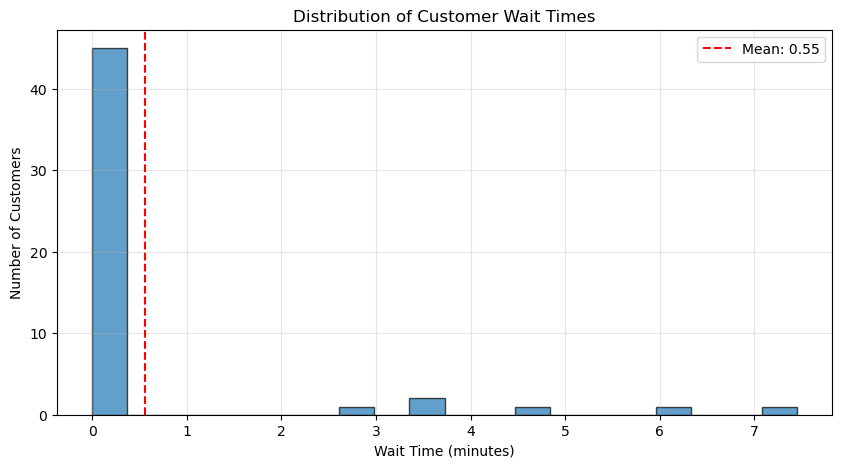

In [16]:
import random
import numpy as np

class Bank:
    def __init__(self, env, num_tellers, num_atms):
        self.env = env
        self.tellers = simpy.Resource(env, capacity=num_tellers)
        self.atms = simpy.Resource(env, capacity=num_atms)
        
        # Statistics
        self.wait_times = []
        self.service_times = []
        self.customers_served = 0
    
    def serve_customer(self, customer_type, duration):
        """Simulate customer service."""
        arrival_time = self.env.now
        
        # Choose resource based on customer type
        if customer_type == 'teller':
            with self.tellers.request() as request:
                yield request
                wait_time = self.env.now - arrival_time
                self.wait_times.append(wait_time)
                
                yield self.env.timeout(duration)
                self.service_times.append(duration)
        else:  # ATM
            with self.atms.request() as request:
                yield request
                wait_time = self.env.now - arrival_time
                self.wait_times.append(wait_time)
                
                yield self.env.timeout(duration)
                self.service_times.append(duration)
        
        self.customers_served += 1

def customer_generator(env, bank, customer_type, mean_interarrival, mean_service):
    """Generate customers arriving at the bank."""
    customer_count = 0
    
    while True:
        # Wait for next customer arrival (exponential distribution)
        yield env.timeout(random.expovariate(1.0 / mean_interarrival))
        
        customer_count += 1
        service_time = random.expovariate(1.0 / mean_service)
        
        print(f'👤 {customer_type.upper()}-Customer-{customer_count} arrives at {env.now:.2f}')
        env.process(bank.serve_customer(customer_type, service_time))

# Simulation parameters
RANDOM_SEED = 42
NUM_TELLERS = 2
NUM_ATMS = 3
SIM_TIME = 50
TELLER_INTERARRIVAL = 3.0  # Average time between teller customers
TELLER_SERVICE = 5.0       # Average teller service time
ATM_INTERARRIVAL = 2.0     # Average time between ATM customers
ATM_SERVICE = 2.0          # Average ATM service time

# Run simulation
random.seed(RANDOM_SEED)
env = simpy.Environment()
bank = Bank(env, NUM_TELLERS, NUM_ATMS)

# Start customer generators
env.process(customer_generator(env, bank, 'teller', TELLER_INTERARRIVAL, TELLER_SERVICE))
env.process(customer_generator(env, bank, 'atm', ATM_INTERARRIVAL, ATM_SERVICE))

# Run simulation
env.run(until=SIM_TIME)

# Print statistics
print(f"\n{'='*60}")
print(f"📊 BANK SIMULATION RESULTS")
print(f"{'='*60}")
print(f"Simulation Time: {SIM_TIME} minutes")
print(f"Customers Served: {bank.customers_served}")
print(f"\nWait Times:")
print(f"  Average: {np.mean(bank.wait_times):.2f} minutes")
print(f"  Maximum: {np.max(bank.wait_times):.2f} minutes")
print(f"  Minimum: {np.min(bank.wait_times):.2f} minutes")
print(f"\nService Times:")
print(f"  Average: {np.mean(bank.service_times):.2f} minutes")
print(f"\nResource Utilization:")
print(f"  Tellers: {NUM_TELLERS} tellers")
print(f"  ATMs: {NUM_ATMS} machines")

# Visualize wait times
plt.figure(figsize=(10, 5))
plt.hist(bank.wait_times, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Wait Times')
plt.axvline(np.mean(bank.wait_times), color='red', linestyle='--', label=f'Mean: {np.mean(bank.wait_times):.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 15. Advanced: Custom Events

You can create custom events for more complex simulation scenarios.

In [17]:
class LightSwitch:
    """A custom event-based light switch."""
    def __init__(self, env):
        self.env = env
        self.is_on = False
        self.on_event = env.event()
        self.off_event = env.event()
    
    def turn_on(self):
        """Turn the light on."""
        if not self.is_on:
            self.is_on = True
            self.on_event.succeed()
            self.on_event = self.env.event()  # Create new event for next time
            print(f'💡 Light turned ON at {self.env.now}')
    
    def turn_off(self):
        """Turn the light off."""
        if self.is_on:
            self.is_on = False
            self.off_event.succeed()
            self.off_event = self.env.event()  # Create new event for next time
            print(f'🌙 Light turned OFF at {self.env.now}')

def person(env, name, light_switch, wait_time):
    """Person waits for light to turn on."""
    yield env.timeout(wait_time)
    print(f'👤 {name} waiting for light at {env.now}')
    yield light_switch.on_event
    print(f'👤 {name} sees light is on at {env.now}!')

def timer(env, light_switch):
    """Automatic timer that controls the light."""
    while True:
        yield env.timeout(3)
        light_switch.turn_on()
        yield env.timeout(2)
        light_switch.turn_off()

env = simpy.Environment()
light = LightSwitch(env)

# Start timer and people
env.process(timer(env, light))
env.process(person(env, 'Alice', light, 1))
env.process(person(env, 'Bob', light, 4))

env.run(until=10)

👤 Alice waiting for light at 1
💡 Light turned ON at 3
👤 Alice sees light is on at 3!
👤 Bob waiting for light at 4
🌙 Light turned OFF at 5
💡 Light turned ON at 8
👤 Bob sees light is on at 8!


## Summary: SimPy Resource Types

| Resource Type | Description | Use Case |
|--------------|-------------|----------|
| **Resource** | Basic limited-capacity resource | Servers, parking spots, checkout counters |
| **PriorityResource** | Resource with priority queuing | Emergency rooms, VIP customers |
| **PreemptiveResource** | Resource with preemption | CPU scheduling, critical tasks |
| **Container** | Continuous/bulk resource | Fuel tanks, water reservoirs, inventory |
| **Store** | Discrete object storage | Production queues, message buffers |
| **FilterStore** | Store with filtered retrieval | Tool selection, specialized equipment |
| **PriorityStore** | Store with priority ordering | Bug trackers, task queues |

## Key SimPy Concepts to Remember

1. **Environment (`env`)**: The simulation world that manages time
2. **Processes**: Generator functions that use `yield` to pause/resume
3. **Timeout**: `env.timeout(duration)` - Wait for time to pass
4. **Resources**: Limited-capacity objects that processes compete for
5. **Events**: Objects that trigger at specific times
6. **Context Manager**: Use `with resource.request() as req:` for automatic release
7. **Monitoring**: Track statistics during simulation for analysis

## Transportation Engineering Applications

SimPy is excellent for:
- **Traffic Signal Simulation**: Model vehicle arrivals and signal phases
- **Intersection Analysis**: Queue lengths, delays, level of service
- **Transit Systems**: Bus schedules, passenger boarding/alighting
- **Parking Facilities**: Space utilization, waiting times
- **Toll Plazas**: Lane allocation, throughput analysis
- **Highway Weaving Sections**: Merge/diverge conflicts
- **Roundabouts**: Entry/exit patterns, gap acceptance

## 16. Practice Exercise: Traffic Intersection Simulation

Try building your own traffic intersection simulation!

🟢 NS Green, 🔴 EW Red at 0.0
🚗 EW-V1 (EW) arrives at 0.1
   EW-V1 crosses at 0.1 (waited 0.0)
🚗 EW-V2 (EW) arrives at 1.4
   EW-V2 crosses at 2.1 (waited 0.7)
🚗 EW-V3 (EW) arrives at 2.4
🚗 NS-V1 (NS) arrives at 3.1
   EW-V3 crosses at 4.1 (waited 1.7)
🚗 NS-V2 (NS) arrives at 6.4
🚗 EW-V4 (EW) arrives at 7.7
   EW-V4 crosses at 7.7 (waited 0.0)
🚗 EW-V5 (EW) arrives at 8.1
   EW-V5 crosses at 9.7 (waited 1.6)
🔴 NS Red, 🟢 EW Green at 10.0
   NS-V1 crosses at 10.0 (waited 6.9)
🚗 EW-V6 (EW) arrives at 10.3
🚗 EW-V7 (EW) arrives at 10.4
🚗 EW-V8 (EW) arrives at 11.4
   NS-V2 crosses at 12.0 (waited 5.6)
🚗 NS-V3 (NS) arrives at 13.1
🚗 NS-V4 (NS) arrives at 13.2
🚗 NS-V5 (NS) arrives at 13.9
   NS-V3 crosses at 14.0 (waited 0.9)
🚗 EW-V9 (EW) arrives at 14.2
   NS-V4 crosses at 16.0 (waited 2.8)
🚗 NS-V6 (NS) arrives at 17.0
🚗 EW-V10 (EW) arrives at 17.4
🚗 NS-V7 (NS) arrives at 17.8
   NS-V5 crosses at 18.0 (waited 4.1)
🟢 NS Green, 🔴 EW Red at 19.7
   EW-V6 crosses at 19.7 (waited 9.4)
   NS-V6 cross

/tmp/ipykernel_26589/2516684080.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([intersection.wait_times['NS'], intersection.wait_times['EW']],


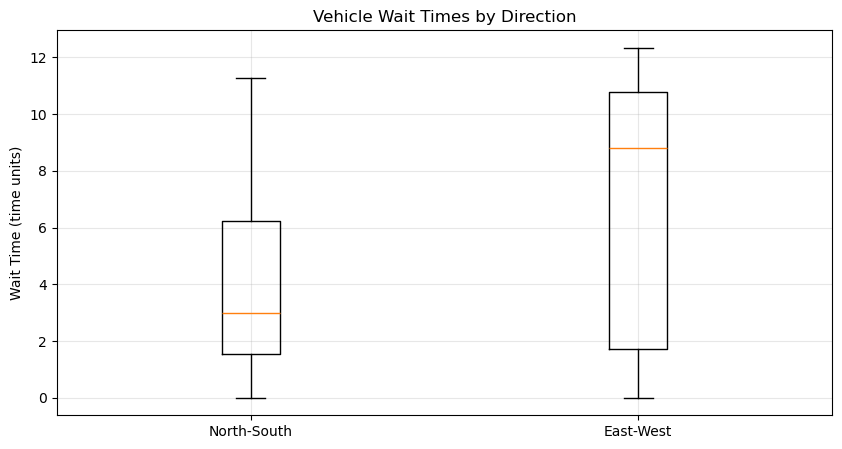

In [18]:
class TrafficIntersection:
    """A traffic intersection with signal control."""
    def __init__(self, env, green_time_ns, green_time_ew):
        self.env = env
        self.green_time_ns = green_time_ns  # North-South green time
        self.green_time_ew = green_time_ew  # East-West green time
        
        # Each direction has capacity 1 (only one direction can go at a time)
        self.ns_signal = simpy.Resource(env, capacity=1)
        self.ew_signal = simpy.Resource(env, capacity=1)
        
        # Statistics
        self.vehicles_passed = {'NS': 0, 'EW': 0}
        self.wait_times = {'NS': [], 'EW': []}
        
        # Start signal controller
        env.process(self.signal_controller())
    
    def signal_controller(self):
        """Control traffic signals alternating between NS and EW."""
        while True:
            # North-South green
            print(f'🟢 NS Green, 🔴 EW Red at {self.env.now:.1f}')
            ns_request = self.ns_signal.request()
            yield ns_request
            yield self.env.timeout(self.green_time_ns)
            self.ns_signal.release(ns_request)
            
            # East-West green
            print(f'🔴 NS Red, 🟢 EW Green at {self.env.now:.1f}')
            ew_request = self.ew_signal.request()
            yield ew_request
            yield self.env.timeout(self.green_time_ew)
            self.ew_signal.release(ew_request)

def vehicle(env, name, intersection, direction, arrival_time):
    """Vehicle approaching intersection."""
    yield env.timeout(arrival_time)
    arrival = env.now
    
    print(f'🚗 {name} ({direction}) arrives at {env.now:.1f}')
    
    # Choose appropriate signal
    signal = intersection.ns_signal if direction == 'NS' else intersection.ew_signal
    
    with signal.request() as req:
        yield req
        wait_time = env.now - arrival
        intersection.wait_times[direction].append(wait_time)
        
        print(f'   {name} crosses at {env.now:.1f} (waited {wait_time:.1f})')
        yield env.timeout(2)  # Crossing time
        intersection.vehicles_passed[direction] += 1

def vehicle_generator(env, intersection, direction, arrival_rate):
    """Generate vehicles from a direction."""
    count = 0
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        count += 1
        env.process(vehicle(env, f'{direction}-V{count}', intersection, direction, 0))

# Run simulation
random.seed(42)
env = simpy.Environment()
intersection = TrafficIntersection(env, green_time_ns=10, green_time_ew=8)

# Generate vehicles from both directions
env.process(vehicle_generator(env, intersection, 'NS', 1/3))  # 1 vehicle every 3 time units
env.process(vehicle_generator(env, intersection, 'EW', 1/4))  # 1 vehicle every 4 time units

# Run simulation
env.run(until=50)

# Display statistics
print(f"\n{'='*60}")
print(f"🚦 INTERSECTION SIMULATION RESULTS")
print(f"{'='*60}")
for direction in ['NS', 'EW']:
    passed = intersection.vehicles_passed[direction]
    waits = intersection.wait_times[direction]
    avg_wait = np.mean(waits) if waits else 0
    max_wait = np.max(waits) if waits else 0
    
    print(f"\n{direction} Direction:")
    print(f"  Vehicles Passed: {passed}")
    print(f"  Average Wait: {avg_wait:.2f} time units")
    print(f"  Maximum Wait: {max_wait:.2f} time units")

# Visualize wait times
plt.figure(figsize=(10, 5))
plt.boxplot([intersection.wait_times['NS'], intersection.wait_times['EW']], 
            labels=['North-South', 'East-West'])
plt.ylabel('Wait Time (time units)')
plt.title('Vehicle Wait Times by Direction')
plt.grid(True, alpha=0.3)
plt.show()

## Additional Resources

- **Official Documentation**: [https://simpy.readthedocs.io](https://simpy.readthedocs.io)
- **Examples Gallery**: [https://simpy.readthedocs.io/en/latest/examples/](https://simpy.readthedocs.io/en/latest/examples/)

## What's Next?

Now you can:
1. Model real-world systems with discrete events
2. Analyze resource utilization and queuing
3. Collect and visualize simulation statistics
4. Design experiments to optimize system performance

**Happy Simulating!** 🎉